# Test

In [2]:
from climso.detection import radialArray, maxRadius, getProminencePositions

import os, re
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import numpy as np


In [6]:
base_dir='Y:/data/CLIMSO/2024/data_calibrated/2024-07-20/'
files = [base_dir+file for file in os.listdir(base_dir) if file.startswith('imoa_06563_c1_')]

def extract_timestamp(file_path):
    match = re.search(r'\d{8}_\d{8}', file_path)
    if match:
        return match.group(0)
    return ''

files = sorted(files, key=extract_timestamp)
    
files

['Y:/data/CLIMSO/2024/data_calibrated/2024-07-20/imoa_06563_c1_20240720_06055568_bri1.fts.bz2',
 'Y:/data/CLIMSO/2024/data_calibrated/2024-07-20/imoa_06563_c1_20240720_06074474_bri1.fts.bz2',
 'Y:/data/CLIMSO/2024/data_calibrated/2024-07-20/imoa_06563_c1_20240720_06111447_bri1.fts.bz2',
 'Y:/data/CLIMSO/2024/data_calibrated/2024-07-20/imoa_06563_c1_20240720_06123511_bri1.fts.bz2',
 'Y:/data/CLIMSO/2024/data_calibrated/2024-07-20/imoa_06563_c1_20240720_06152664_bri1.fts.bz2',
 'Y:/data/CLIMSO/2024/data_calibrated/2024-07-20/imoa_06563_c1_20240720_06162683_bri1.fts.bz2',
 'Y:/data/CLIMSO/2024/data_calibrated/2024-07-20/imoa_06563_c1_20240720_06172657_bri1.fts.bz2',
 'Y:/data/CLIMSO/2024/data_calibrated/2024-07-20/imoa_06563_c1_20240720_06222710_bri1.fts.bz2',
 'Y:/data/CLIMSO/2024/data_calibrated/2024-07-20/imoa_06563_c1_20240720_06232765_bri1.fts.bz2',
 'Y:/data/CLIMSO/2024/data_calibrated/2024-07-20/imoa_06563_c1_20240720_06242568_bri1.fts.bz2',
 'Y:/data/CLIMSO/2024/data_calibrated/20

In [7]:
files = files[-10:]

In [8]:
prom_deg = getProminencePositions(files[0])
prom_deg

[131, 262]

In [9]:
deg = prom_deg[0]

max_radiuses = []
degs    = []
times   = []
speeds  = []
fileset = []

for n in range(1, len(files)):
    array1, date_obs1 = radialArray(files[n-1])
    array2, date_obs2 = radialArray(files[n])

    max_radius_entry_1 = maxRadius(array1, deg)
    if max_radius_entry_1 is None: continue
    max_radius_entry_2 = maxRadius(array2, max_radius_entry_1['deg'])
    if max_radius_entry_2 is None: continue
    
    deg = int(max_radius_entry_2['deg'])

    distance = (max_radius_entry_2['radius'] - max_radius_entry_1['radius'])*696e3 # km
    time = abs(date_obs2 - date_obs1)
    if time.seconds == 0 : continue # to avoid division by zero
    
    speed = distance / time.seconds # km/s
    
    max_radiuses.append(max_radius_entry_1['radius'])
    degs.append(max_radius_entry_1['deg'])
    times.append(date_obs1)
    speeds.append(speed)
    fileset.append(files[n-1])

if max_radius_entry_2:
    max_radiuses.append(max_radius_entry_2['radius'])
    degs.append(max_radius_entry_2['deg'])
    times.append(date_obs2)
    fileset.append(files[-1])

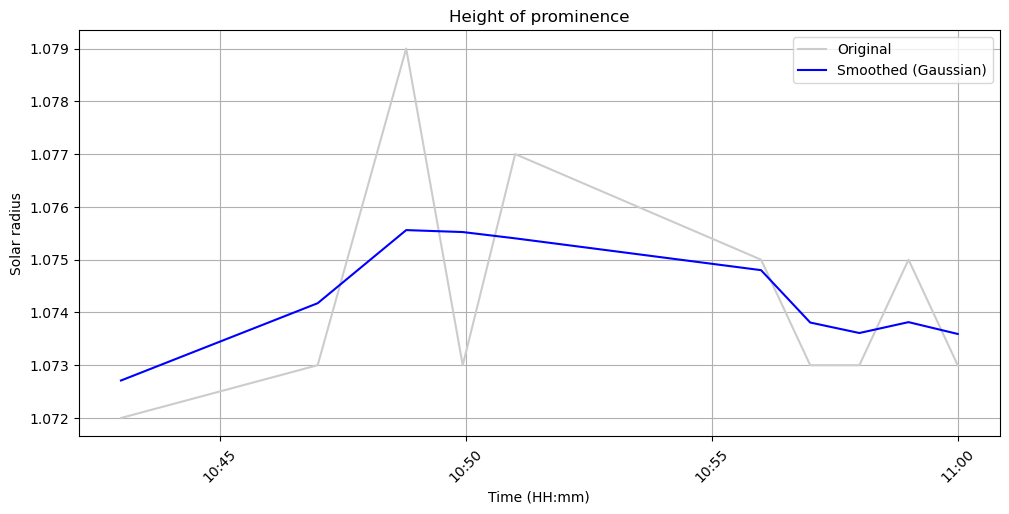

In [10]:
smoothed_max_radiuses = gaussian_filter1d(max_radiuses, sigma=1, radius=5)

plt.figure(figsize=(10, 5))
plt.plot(times, max_radiuses, marker='', linestyle='-', color='0.8', label='Original')
plt.plot(times, smoothed_max_radiuses, marker='', linestyle='-', color='b', label='Smoothed (Gaussian)')

plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

time_format = mdates.DateFormatter('%H:%M')
plt.gca().xaxis.set_major_formatter(time_format)

plt.xlabel('Time (HH:mm)')
plt.ylabel('Solar radius')
plt.title('Height of prominence')
plt.legend();

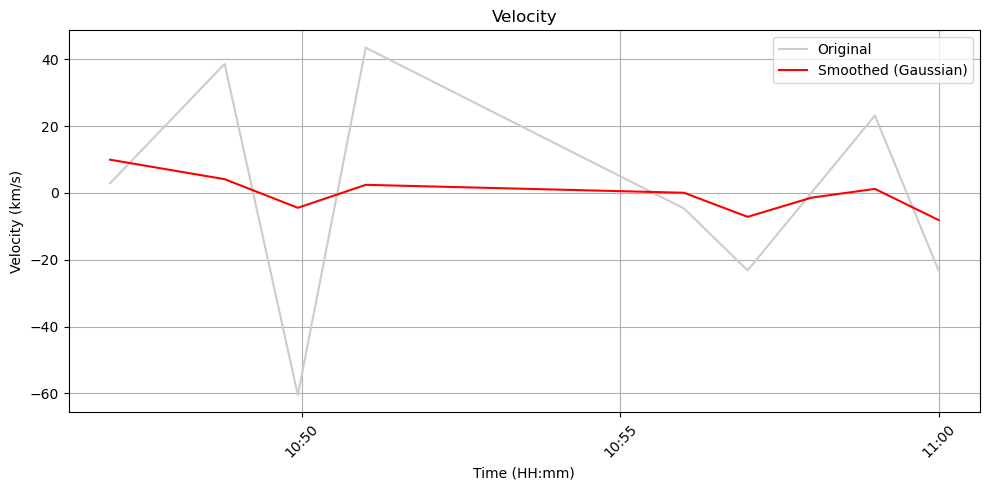

In [11]:
# Generate smoothed values
smoothed_values = gaussian_filter1d(speeds, sigma=1, radius=5)

# Plot the original and smoothed data
plt.figure(figsize=(10, 5))
plt.plot(times[-len(speeds):], speeds, marker='', linestyle='-', color = '0.8', label='Original')
plt.plot(times[-len(speeds):], smoothed_values, marker='', linestyle='-', color='r', label='Smoothed (Gaussian)')
plt.title('Velocity')
plt.xlabel('Time (HH:mm)')
plt.ylabel('Velocity (km/s)')
plt.grid(True)
plt.xticks(rotation=45)
time_format = mdates.DateFormatter('%H:%M')
plt.gca().xaxis.set_major_formatter(time_format)
plt.tight_layout()
plt.legend();

In [12]:
idx=-1

0


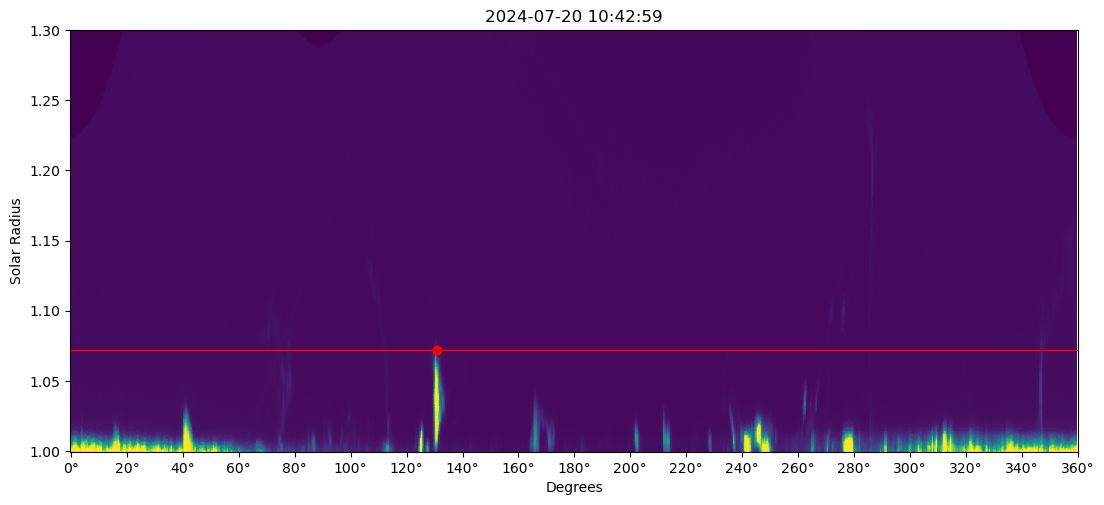

In [13]:
idx += 1
print(idx)

arr, date_obs = radialArray(files[idx])

fig, ax = plt.subplots(figsize=(13,6))
plt.imshow(arr, origin='lower')
plt.axhline(y=int((max_radiuses[idx]-1)*1e3), color='red', linestyle='-', linewidth=1)
#plt.axvline(x=int(degs[idx]*2), color='r', linestyle='--', linewidth=1)
plt.plot(int(degs[idx]*2), int((max_radiuses[idx]-1)*1e3), 'ro')

xticks = np.linspace(0, 360, 19)
ax.set_xticks(np.linspace(0, 720, 19))
ax.set_xticklabels([f'{xtick:.0f}°' for xtick in xticks])
plt.xlabel('Degrees')

yticks = np.linspace(1, 1+(len(arr)-1)*1e-3, 7)
ax.set_yticks(np.linspace(0, len(arr), 7))
ax.set_yticklabels([f'{ytick:.2f}' for ytick in yticks])

plt.ylabel('Solar Radius')

plt.title(times[idx]);

In [32]:
from astropy.io import fits
import math

file=files[0]
threshold = 20000

r_coeff = 1.05

with fits.open(file) as hdul:
    data = np.flip(hdul[0].data, axis=0)
            
    r = hdul[0].header['rsun_obs']*r_coeff

# Generate circle
circle = []
stepSize = math.pi/360.0        
t0 = math.pi/2.0
t = t0
while t < 2 * math.pi+t0:
    circle.append((round(r * math.sin(t) + 1024), round(r * math.cos(t) + 1024)))
    t += stepSize

# Get line from circle
line = [data[coord] for coord in circle]

# Find indices where line values exceed the threshold
indices = np.where(np.array(line) > threshold)[0]

# group indices into continuous regions considering the circular nature
groups = []
current_group = [indices[0]]
length = len(line)

for i in range(1, len(indices)):
    if indices[i] == indices[i-1] + 1 or (indices[i] == 0 and indices[i-1] == length - 1):
        current_group.append(indices[i])
    else:
        groups.append(current_group)
        current_group = [indices[i]]
groups.append(current_group)

# Handle circular connection between last and first group
if groups[0][0] == 0 and groups[-1][-1] == length - 1:
    groups[0] = groups[-1] + groups[0]
    groups.pop()

# Calculate the central index for each spike group
central_indices = [group[len(group)//2] for group in groups]

central_indices

[263]

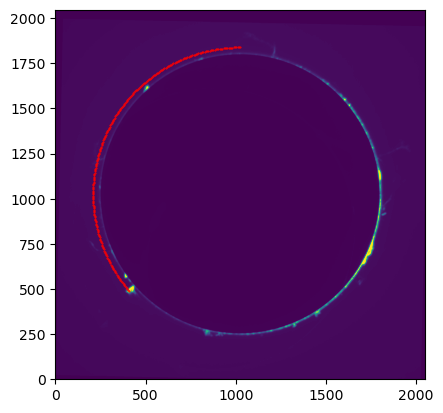

In [33]:
with fits.open(file) as hdul:
    data = np.flip(hdul[0].data, axis=0)
    
plt.imshow(data, origin='lower')
plt.scatter([coord[1] for coord in circle[:central_indices[0]]],[coord[0] for coord in circle[:central_indices[0]]], marker='.', s=1, c='r')

In [34]:
line = [data[coord] for coord in circle]

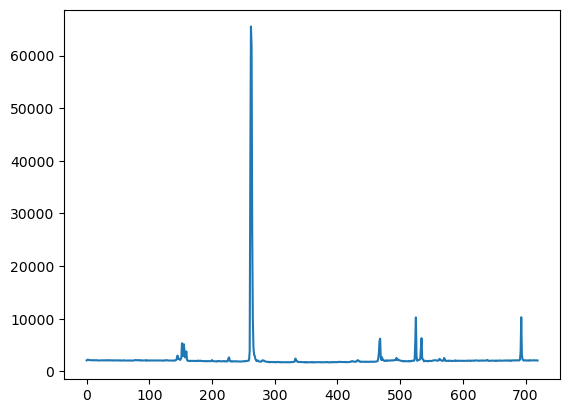

In [35]:
plt.plot(line)

In [23]:
from climso.maps import SynopticMap

syn_map = SynopticMap(climso_dir='Y:/data/CLIMSO/',rotation=2286, disk='l2')

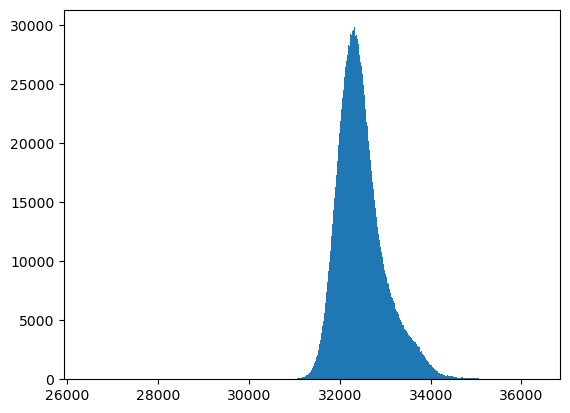

In [24]:
plt.hist(syn_map.data.flatten(), bins='auto');

Text(0.5, 1.0, 'L2')

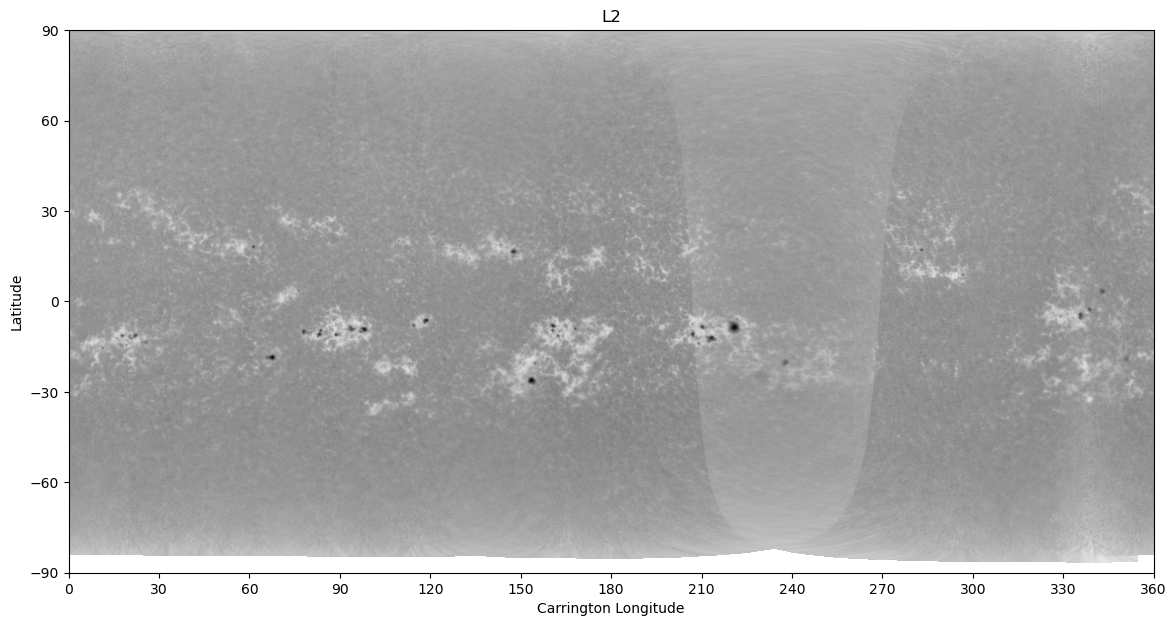

In [25]:
syn_map.plot(cmap='grey',figsize=(14,14))
plt.title('L2')

### AR

In [2]:
import os

base_dir='Y:/data/CLIMSO/2024/data_calibrated/2024-07-14/'

files = [base_dir+file for file in os.listdir(base_dir) if file.startswith('imoa_03933_l2_')]


In [3]:
files[0]

'Y:/data/CLIMSO/2024/data_calibrated/2024-07-14/imoa_03933_l2_20240714_09011769_emi1.fts.bz2'

In [4]:
from climso.utils import toSunpyMap
from climso.detection import ActiveRegions

map = toSunpyMap(files[0])

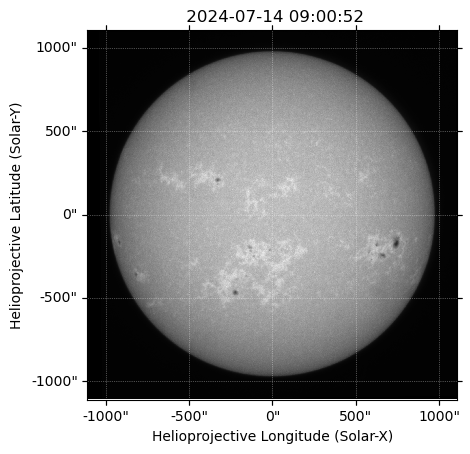

In [5]:
map.plot()

In [6]:
ar = ActiveRegions(map)

<Figure size 800x800 with 0 Axes>

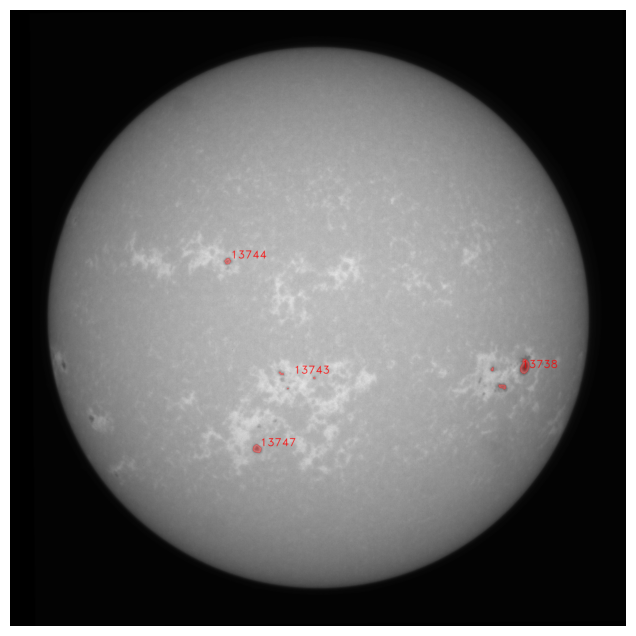

In [7]:
ar.plot()

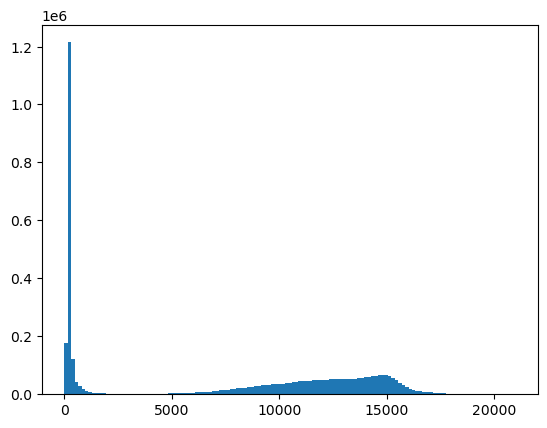

In [8]:
import matplotlib.pyplot as plt
plt.hist(ar.map.data.flatten(), bins='auto');

In [9]:
ar.table

number,latitude,longitude,x,y,area
,deg,deg,pix,pix,uSH
int32,float64,float64,float64,float64,float64
13738,-8.87,50.56,1691.0,848.0,440.63
13743,-8.54,-5.99,933.0,829.0,24.52
13744,16.42,-20.97,723.0,1212.0,60.83
13747,-25.7,-14.91,821.0,588.0,133.11


(-0.5, 399.5, -0.5, 399.5)

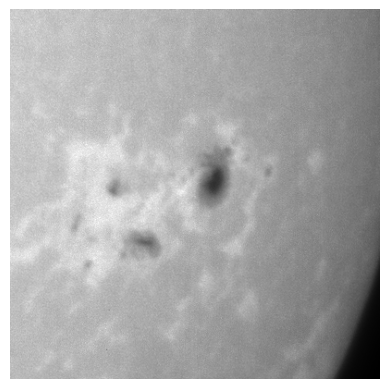

In [10]:
region = ar.table[ar.table['number']==13738][0]
x = int(region['x'].value)
y = int(region['y'].value)
plt.imshow(ar.map.data[y-200:y+200, x-200:x+200], origin='lower', cmap='grey')
plt.axis('off')

In [11]:
x, y

(1691, 848)

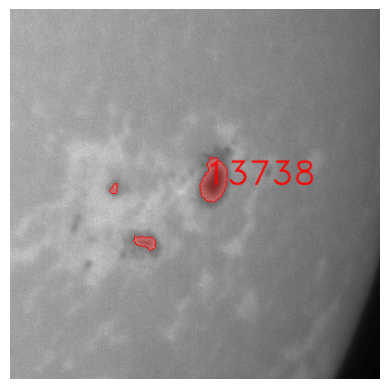

In [9]:
import cv2 as cv
import numpy as np

image = cv.convertScaleAbs(ar.map.data, alpha=(255.0/65535.0)).astype(np.uint8)

# Colors
color = (255,0,0)
weight = np.max(image)/255.0

color_image = np.zeros((ar.active_regions.shape[0], ar.active_regions.shape[1], 3), dtype=np.uint8)
color_image[ar.active_regions==255] = [255,0,0]

img_label = cv.addWeighted(cv.cvtColor(image, cv.COLOR_GRAY2RGB), 1/weight, color_image, weight,0)

contours, _ = cv.findContours(ar.active_regions, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cv.drawContours(img_label, contours, -1, color, 1)

# Numbers
font = cv.FONT_HERSHEY_DUPLEX
fontScale = 1.2
thickness = 1

img_num = img_label.copy()
for ar in ar.table :
    cv.putText(img_num, str(ar['number']), (int(ar['x'].value) + 10, int(ar['y'].value) + 10), font, fontScale, color, thickness, cv.LINE_AA, True)

plt.axis('off')
plt.imshow(img_num[y-200:y+200, x-200:x+200], origin='lower', cmap='grey');